# **Conectar la carpeta de drive de su correo electronico**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Cargar librerias**

In [2]:
import os.path  # Importa el módulo os.path para trabajar con rutas de archivos
import os
import pandas as pd  # Importa la biblioteca pandas y la abrevia como pd para trabajar con datos estructurados
import datetime  # Importa el módulo datetime para trabajar con fechas y horas
import matplotlib.pyplot as plt  # Importa la biblioteca matplotlib.pyplot para trazar gráficos
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns # para gráficos
import numpy as np # manejo de matrices

# **Organizar y procesar los datos crudos del IDEAM**

Concatenar todos los archivos con datos del IDEAM, filtrarlos tan solo a los valores y organizarlos por columnas cada estación

In [3]:
path = '/content/drive/MyDrive/IDEAM-PROCESAMIENTO/input' # Obtiene el directorio de trabajo actual
os.chdir(path)
directorio = os.listdir()  # Obtiene una lista de todos los archivos y directorios en el directorio actual
data = []  # Inicializa una lista vacía para almacenar los datos de los archivos CSV
for archivo in directorio:  # Itera sobre cada archivo en el directorio
    nombre, extension = os.path.splitext(archivo)  # Divide el nombre del archivo y su extensión
    if extension == '.csv':  # Verifica si la extensión del archivo es '.csv'
        data.append(pd.read_csv(archivo, dtype={11: 'str'} ))  # Lee el archivo CSV y lo agrega a la lista de datos
datos_unidos = pd.concat(data)  # Combina todos los DataFrames de la lista en uno solo
datos_unidos['data'] = pd.to_datetime(datos_unidos['Fecha'])  # Convierte la columna 'Fecha' en formato datetime
nombre_estacion = datos_unidos['CodigoEstacion'].unique()  # Obtiene valores únicos de la columna 'CodigoEstacion'
datos_unidos = datos_unidos[["Fecha", "Valor", "NombreEstacion"]]  # Selecciona solo las columnas necesarias
datos_organizados = datos_unidos.pivot_table(index="Fecha", columns="NombreEstacion", values="Valor") # Crea una tabla pivot con la fecha como índice # Organiza los datos por estación
datos_organizados = datos_organizados.reset_index()  # Resetea el índice para convertir 'Fecha' en una columna
datos_organizados['Fecha'] = pd.to_datetime(datos_organizados['Fecha'])  # Convierte la columna 'Fecha' en datetime
datos_organizados['Fecha'] = datos_organizados['Fecha'].dt.date  # Extrae solo la fecha (sin hora) de 'Fecha'
datos_organizados.head(2)  # Muestra las primeras 2 filas de los datos organizados

NombreEstacion,Fecha,ACACIAS [35010020],ACUEDUCTO LA ESMERALDA [35030040],AEROPUERTO VANGUARDIA [35035020],AGUAS CLARAS [32070110],ALCALDIA [35030100],ALTO DEL TIGRE [35035090],APIAY [35030060],BAJO NARE [35010230],BALSORA LA [32030010],...,SAN JUANITO PVM [35030300],SAN LUIS CUBARRAL [32060030],SAN MARTIN [35010090],SENA [35030030],SERVITA [35030290],STA HELENA [35010110],TIERRA GRATA [32070080],UNILLANOS [35035070],VISTA HERMOSA [32075030],YAGUARITO [35010150]
0,1970-01-01,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-01-02,5.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# importar base de datos
datos_organizados.to_excel('/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_organizados.xlsx', index=False)
datos_estacion = pd.read_excel('/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_organizados.xlsx',index_col=0,parse_dates=True)

# **Gráficar datos organizados**
Se genera el gráfico con los datos organizados

In [5]:
# Selecciona todas las columnas de datos_estacion (presumiblemente un DataFrame)
# excepto la primera, que suele ser la columna de fechas, y asigna estas columnas a la variable 'estaciones'
datos_estacion = datos_organizados.copy()
datos_estacion = datos_estacion.set_index('Fecha')
estaciones = datos_estacion.columns[:]
# Crea una figura y un conjunto de ejes utilizando subplots de matplotlib.
# El número de subplots se determina por la cantidad de estaciones. Se configura el tamaño de la figura en función del número de estaciones para que las gráficas no se superpongan.
# sharex=True comparte el mismo eje x entre todos los subplots.
fig, axs = plt.subplots(len(estaciones), 1, figsize=(18, len(estaciones)*2), sharex=True)
# Itera sobre el índice y el nombre de cada estación en la lista 'estaciones'
for i, estacion in enumerate(estaciones):
    # Grafica los datos de la estación actual en el subplot correspondiente
    axs[i].plot(datos_estacion.index, datos_estacion[estacion])
    # Configura el título del subplot con el nombre de la estación actual
    axs[i].set_title(estacion)
plt.xlabel("Fecha") # Configura la etiqueta del eje x para toda la figura
plt.show() # Muestra la figura con todos los subplots

Output hidden; open in https://colab.research.google.com to view.

# **Eliminar las estaciones**
Considerando un porcentaje (para la aplicación es del 30%) de datos faltantes entre la fecha de inicio y la fecha final de análisis, las estaciones que no tengan este porcentaje de datos en su serie histórica, se eliminaran.

In [13]:
# Cargar los datos (Ya tienes datos_organizados)
# En lugar de leer el archivo, crea una copia de datos_organizados
datos_estacion = datos_organizados.copy()
# Establece la columna 'Fecha' como el índice
datos_estacion = datos_estacion.set_index('Fecha')
# Asegura que el índice sea de tipo datetime64[ns]
datos_estacion.index = pd.to_datetime(datos_estacion.index)
# 1. Cuenta las estaciones iniciales
cantidad_estaciones_inicial = datos_estacion.shape[1]
print(f"Número de estaciones iniciales: {cantidad_estaciones_inicial}")
total_dias = (datos_estacion.index.max() - datos_estacion.index.min()).days + 1 # Calcular el número total de días desde la fecha inicial hasta la final
# Calcular el 30% del total de días
minimo_dias = total_dias * 0.6
# Encontrar las estaciones que no cumplen con el mínimo de datos
estaciones_a_eliminar = datos_estacion.columns[datos_estacion.count() < minimo_dias]
# Eliminar las estaciones que no cumplen con el mínimo de datos
datos_estacion = datos_estacion.drop(columns=estaciones_a_eliminar)
# 3. Cuenta las estaciones eliminadas
cantidad_estaciones_eliminadas = len(estaciones_a_eliminar)
print(f"Número de estaciones eliminadas: {cantidad_estaciones_eliminadas}")
# 4. Cuenta las estaciones finales
cantidad_estaciones_final = datos_estacion.shape[1]
print(f"Número de estaciones restantes: {cantidad_estaciones_final}")
# Imprimir las estaciones eliminadas
print("Estaciones eliminadas:")
print(estaciones_a_eliminar.tolist())

Número de estaciones iniciales: 98
Número de estaciones eliminadas: 81
Número de estaciones restantes: 17
Estaciones eliminadas:
['ACUEDUCTO LA ESMERALDA [35030040]', 'AGUAS CLARAS [32070110]', 'ALCALDIA [35030100]', 'ALTO DEL TIGRE [35035090]', 'APIAY [35030060]', 'BAJO NARE [35010230]', 'BALSORA LA [32030010]', 'BAMBU EL [35025040]', 'BARBASCAL [35015050]', 'BARRANCA DE UPIA [35105020]', 'BASE AEREA APIAY [35035010]', 'BOCAS DEL DUDA [32020010]', 'BORREGO V RICA HACIENDA [35010050]', 'BUENAVISTA [35030090]', 'CALIME [32060060]', 'CAMPO ALEGRE [32070010]', 'CANDILEJAS [32087040]', 'CARIMAGUA - AUT [33035010]', 'CAÑO BLANCO [32070020]', 'CAÑO HONDO [35010040]', 'CEJALITO [35135010]', 'COOPERATIVA LA [32075060]', 'EL CALVARIO [35030010]', 'EL TORO [35010060]', 'FUENTE DE ORO [32070060]', 'GUADUALITO [35105010]', 'GUAICARAMO [35105050]', 'GUALAS [35015040]', 'GUAMAL [35010070]', 'HACHON EL [35035060]', 'HACIENDA LA CABAÑA [35045020]', 'HIMAT R 6 [35030070]', 'ICA VILLAVICENCIO  - AUT [35

# **Gráfica día, mes y año**
Se genera un gráfico para observa la dinámica a escala día, mes y año de cada estación

<ipython-input-14-0bf753a9db4d>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datos_mensuales_con_nan = datos_estacion.resample('M').sum(min_count=1)
<ipython-input-14-0bf753a9db4d>:3: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_anuales_con_nan = datos_estacion.resample('A').sum(min_count=1)


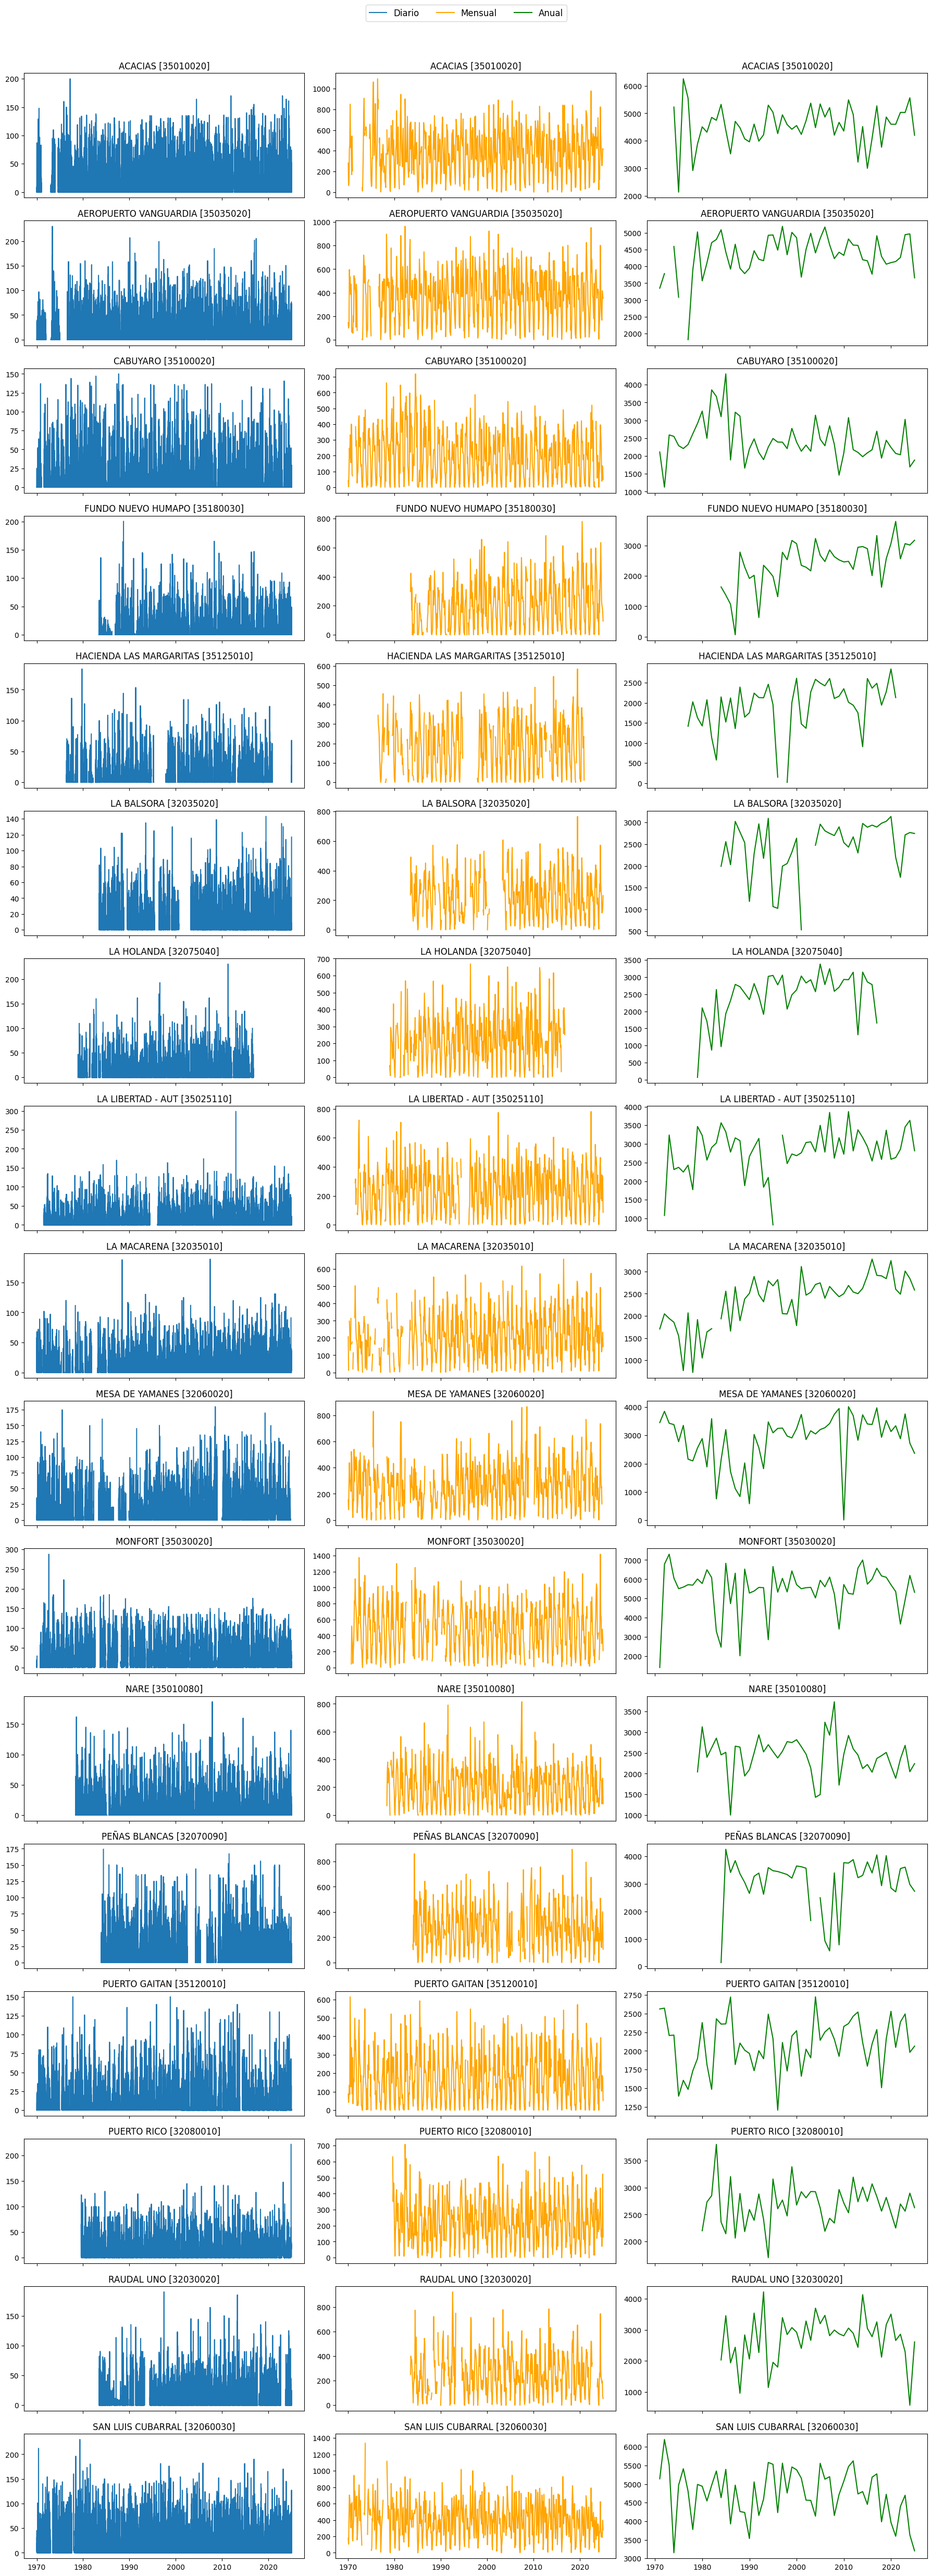

In [14]:
# Calcular las agregaciones mensuales y anuales para cada estación con min_count=1 para manejar NaN
datos_mensuales_con_nan = datos_estacion.resample('M').sum(min_count=1)
datos_anuales_con_nan = datos_estacion.resample('A').sum(min_count=1)

# Preparar la visualización ajustada para tener una única leyenda global
fig, axs = plt.subplots(len(datos_estacion.columns), 3, figsize=(18, len(datos_estacion.columns)*3), sharex='col')
# Crear marcadores para la leyenda única
markers = []
labels = ['Diario', 'Mensual', 'Anual']

for i, estacion in enumerate(datos_estacion.columns):
    # Datos diarios
    line1, = axs[i, 0].plot(datos_estacion.index, datos_estacion[estacion], label='Diario')
    axs[i, 0].set_title(estacion)
    # Datos mensuales con NaN
    line2, = axs[i, 1].plot(datos_mensuales_con_nan.index, datos_mensuales_con_nan[estacion], label='Mensual', color='orange')
    axs[i, 1].set_title(estacion)
    # Datos anuales con NaN
    line3, = axs[i, 2].plot(datos_anuales_con_nan.index, datos_anuales_con_nan[estacion], label='Anual', color='green')
    axs[i, 2].set_title(estacion)
    # Añadir los marcadores solo una vez
    if i == 0:
        markers.extend([line1, line2, line3])

# Colocar la leyenda fuera del área del gráfico con los marcadores
fig.legend(handles=markers, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=3, fontsize='large')
# Ajustar el espacio entre los gráficos y mostrar
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar el layout para acomodar la leyenda en la parte superior
plt.show()

# **Guardar datos día, mes y año**

In [ ]:
# Especificar la ruta y el nombre del archivo de salida
output_file_path = '/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_precipitacion.xlsx'

# Crear un escritor de Pandas Excel
with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
    # Guardar cada DataFrame en una hoja diferente
    datos_estacion.to_excel(writer, sheet_name='Diarios')
    datos_mensuales_con_nan.to_excel(writer, sheet_name='Mensuales')
    datos_anuales_con_nan.to_excel(writer, sheet_name='Anuales')

# Indicar al usuario que la exportación ha sido completada y proporcionar la ruta del archivo
print(f"Los datos han sido exportados exitosamente a {output_file_path}")

Los datos han sido exportados exitosamente a /content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_precipitacion.xlsx


# **Gráficar BOXPLOT**
Con el proposito de observar el comportamiento y la distribución de los datos de precipitación mensualmente, se realiza un gráfico de BOXPLOT para cada estación

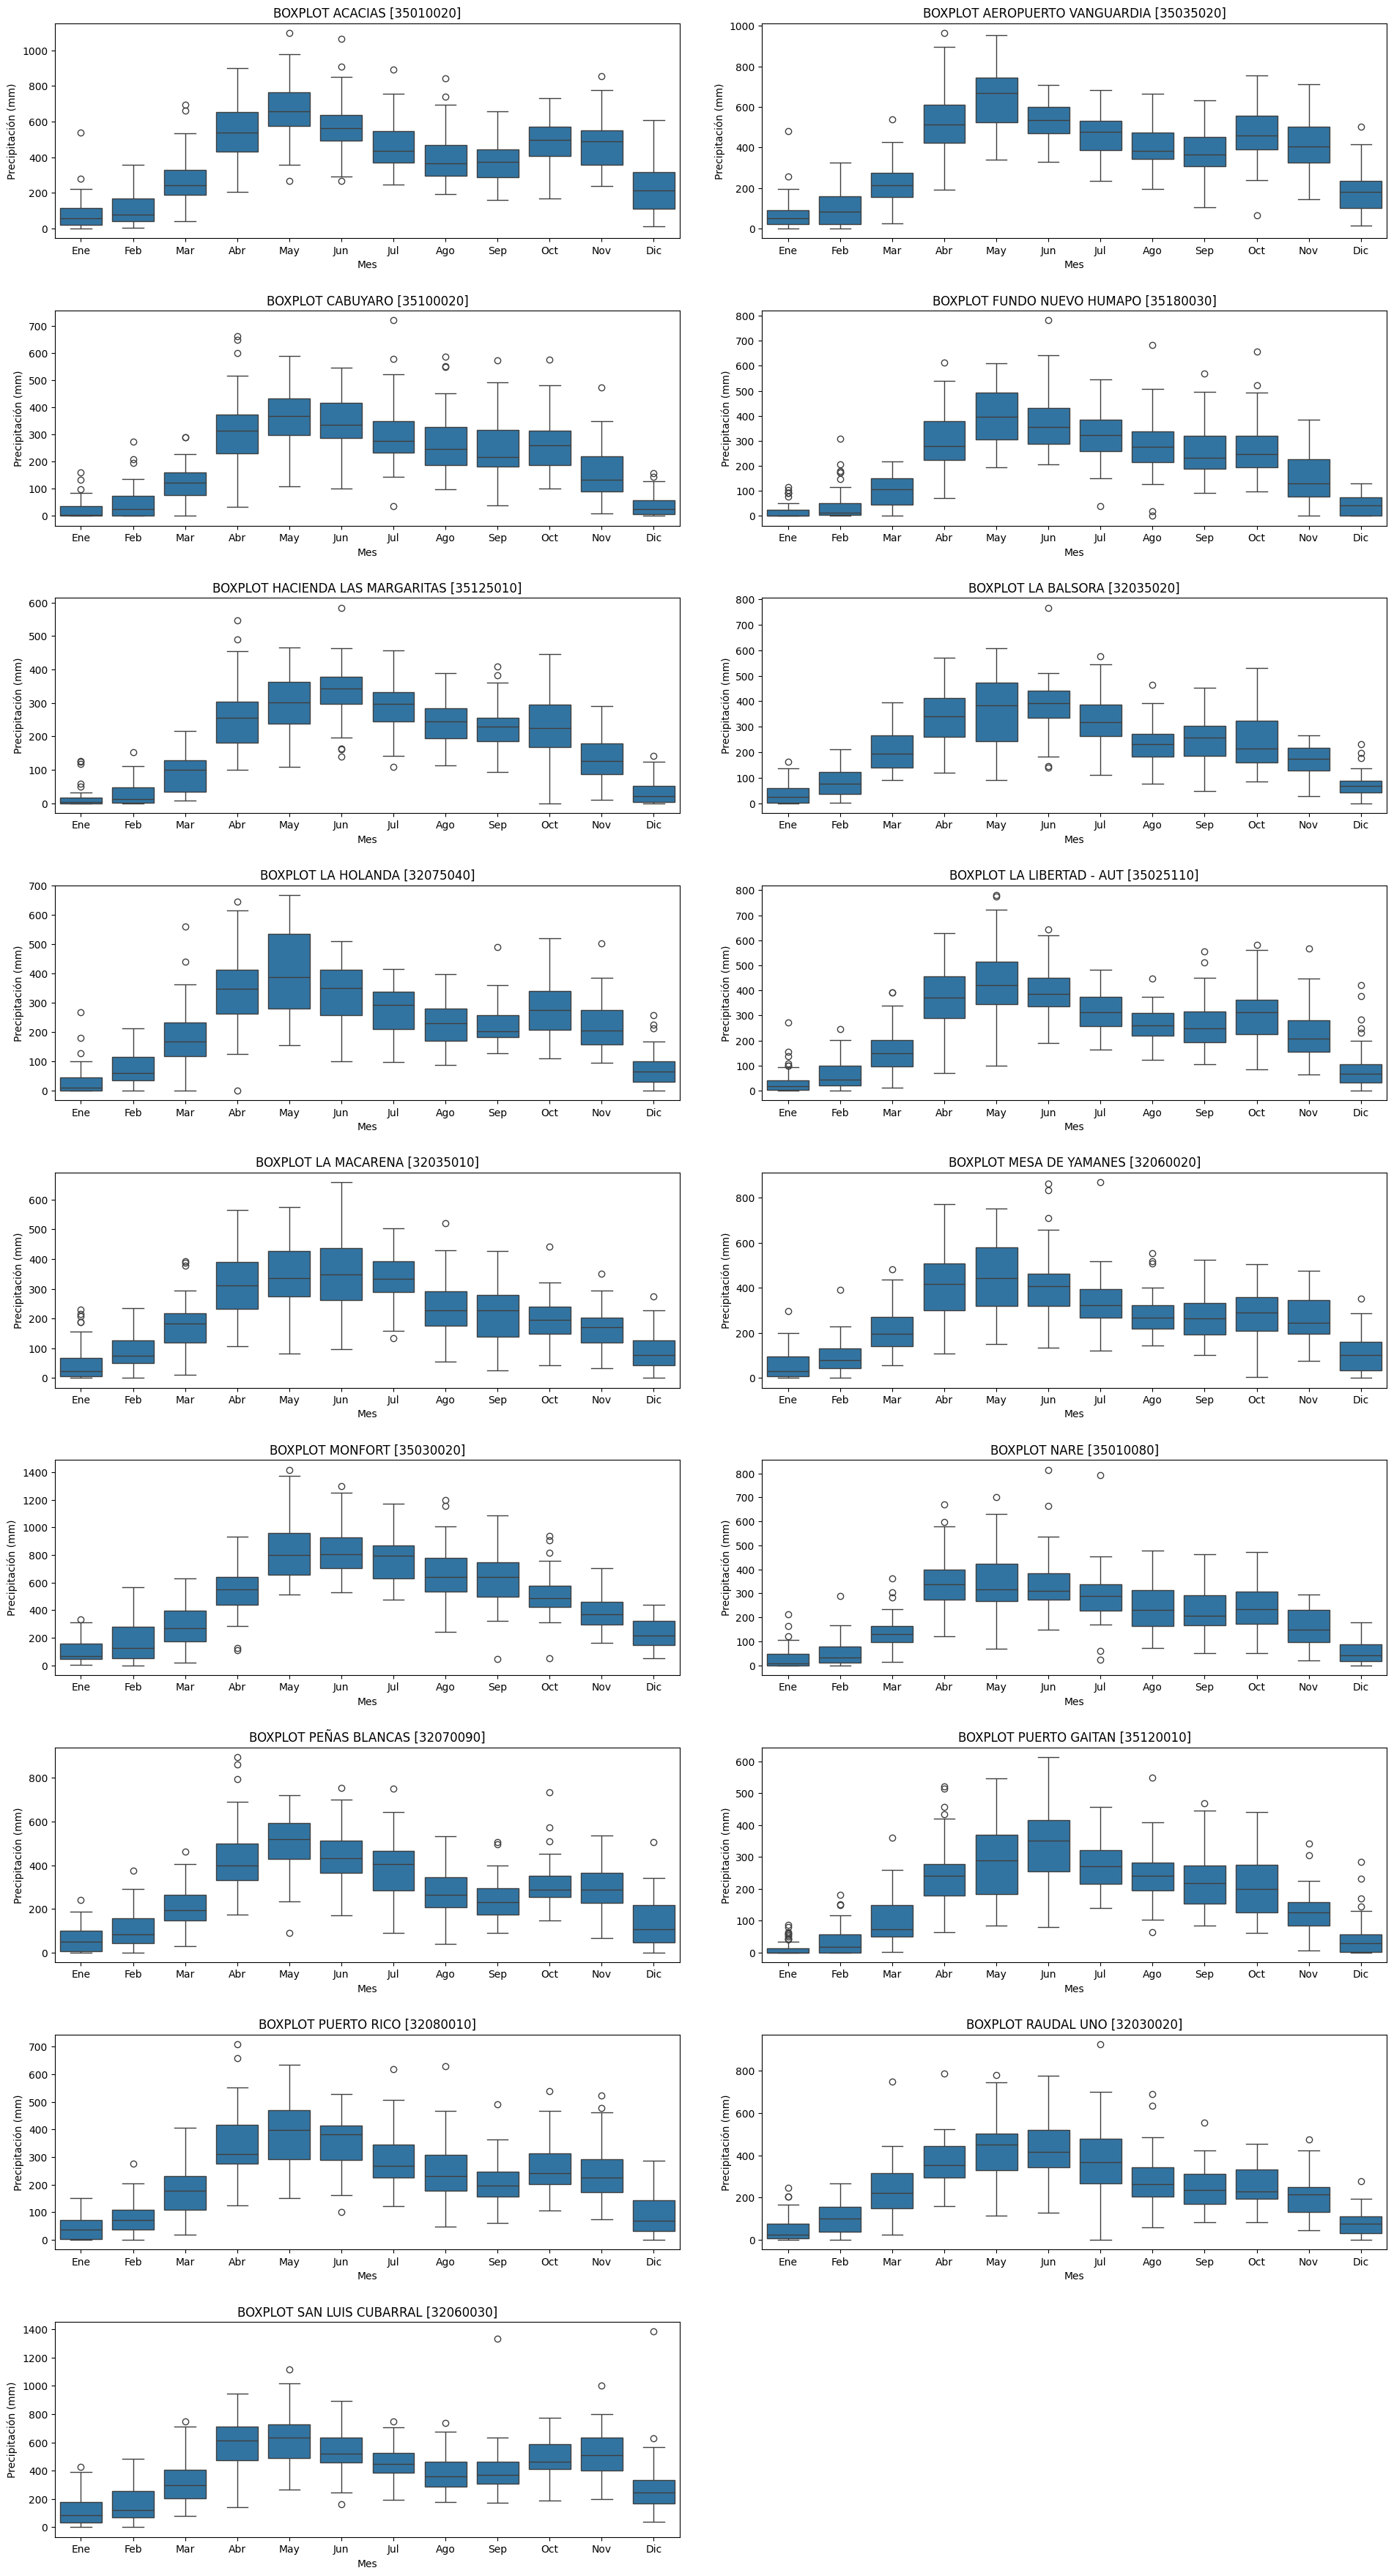

In [ ]:
# Cargar los datos mensuales desde el archivo Excel
datos_mensuales = pd.read_excel('/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_precipitacion.xlsx', sheet_name='Mensuales', index_col=0)
# Asegurar que el índice esté en formato datetime si no lo está
datos_mensuales.index = pd.to_datetime(datos_mensuales.index)
# Extraer el mes y el año de cada fecha
datos_mensuales['Año'] = datos_mensuales.index.year
datos_mensuales['Mes'] = datos_mensuales.index.month

# Preparar los datos para el boxplot una sola vez fuera del bucle
datos_para_boxplot = datos_mensuales.reset_index().melt(id_vars=['Año', 'Mes'], var_name='Estación', value_name='Precipitación')

# Calcular el número de filas necesario para las subplots (cada fila tendrá dos columnas)
n_estaciones = len(datos_mensuales.columns) - 2  # Excluir las columnas 'Año' y 'Mes'
n_filas = (n_estaciones + 1) // 2  # Asegurarse de tener suficientes filas, redondeo hacia arriba

# Crear la figura y los ejes para los subplots
fig, axes = plt.subplots(n_filas, 2, figsize=(20, 4*n_filas)) # Ajusta el tamaño según sea necesario
fig.tight_layout(pad=5.0)  # Ajustar el espaciado entre los plots

# Iterar sobre cada estación y cada par de ejes para crear los boxplots
for i, estacion in enumerate(datos_mensuales.columns[:-2]):
    # Seleccionar el subplot correspondiente
    ax = axes[i//2, i%2]
    # Filtrar los datos para la estación actual
    datos_estacion = datos_para_boxplot[datos_para_boxplot['Estación'] == estacion]
    # Crear el boxplot en el par de ejes correspondiente
    sns.boxplot(x='Mes', y='Precipitación', data=datos_estacion, ax=ax)
    ax.set_title(f'BOXPLOT {estacion}')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Precipitación (mm)')
    # Establecer las etiquetas de los meses con FixedLocator
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(12)))
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

# Ajustar para el caso en que haya un número impar de estaciones, escondiendo el último ax si no se usa
if n_estaciones % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.show()

# **Categorización de Años Hidrológicos**

Intervalo para años secos: <= 2955.73 mm
Intervalo para años normales: > 2955.73 mm y <= 3323.09 mm
Intervalo para años húmedos: > 3323.09 mm


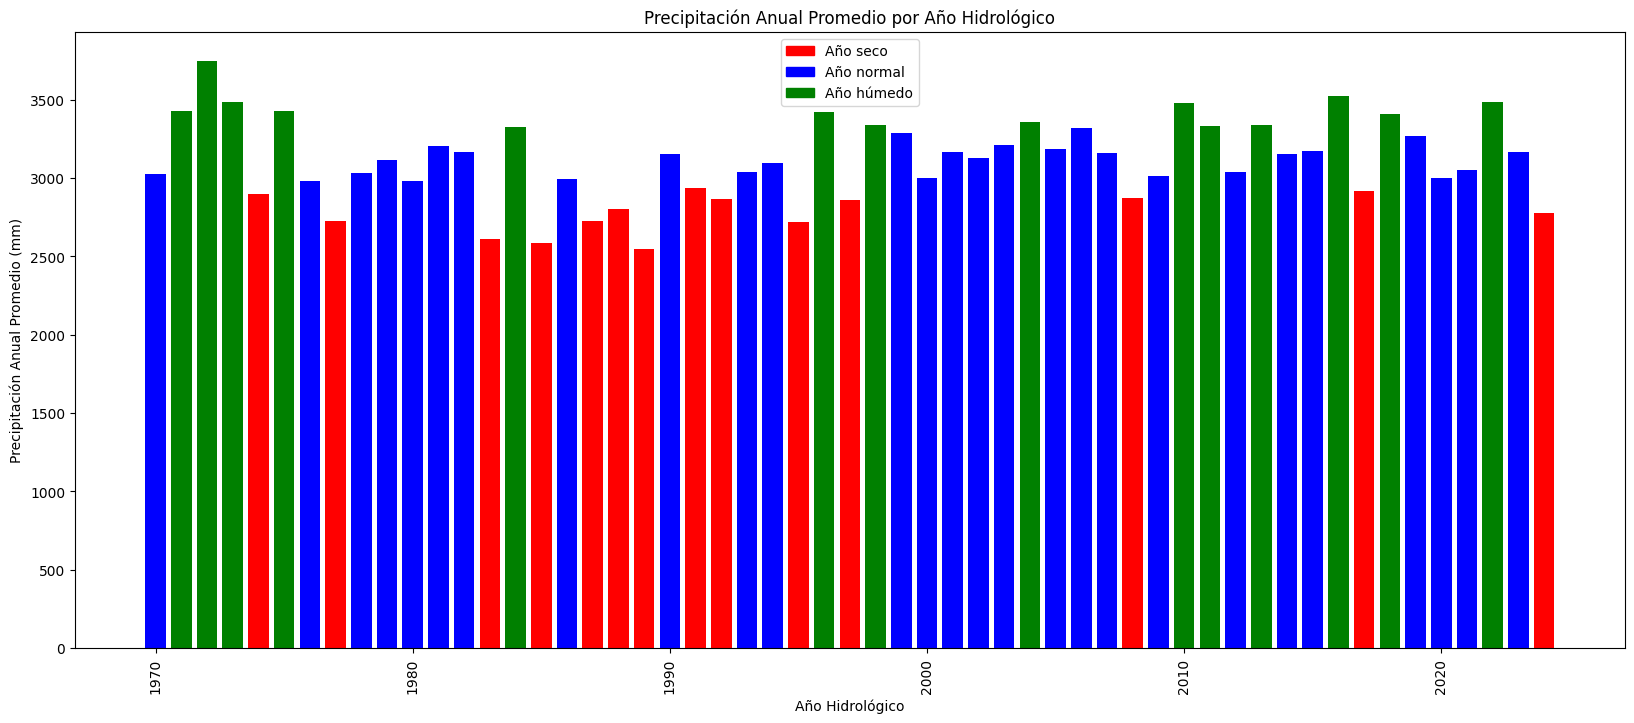

In [ ]:
# Paso 1: Cargar los datos anuales directamente
ruta_archivo = '/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/datos_precipitacion.xlsx'
datos_anuales = pd.read_excel(ruta_archivo, sheet_name='Anuales', parse_dates=['Fecha'])

# Asumiendo que la hoja "Anuales" ya contiene los totales anuales de precipitación por estación,
# y que 'Fecha' indica el año al que corresponden los datos.

# Paso 2: Calcular el promedio anual de todas las estaciones (omitir la columna 'Fecha' en el promedio)
columnas_estaciones = [col for col in datos_anuales.columns if col != 'Fecha']
promedio_anual = datos_anuales[columnas_estaciones].mean(axis=1, skipna=True)
datos_anuales['Precipitacion'] = promedio_anual

# Definir el año hidrológico como el año de 'Fecha'
datos_anuales['Año_Hidrologico'] = datos_anuales['Fecha'].dt.year

# Paso 3: Ya tienes los totales anuales promediados en 'Precipitacion', no necesitas agrupar.

# Paso 4: Categorizar los años basándose en los cuartiles de 'Precipitacion'
q1 = datos_anuales['Precipitacion'].quantile(0.25)
q3 = datos_anuales['Precipitacion'].quantile(0.75)

def categorizar(a):
    if a <= q1:
        return 'seco'
    elif a <= q3:
        return 'normal'
    else:
        return 'humedo'

datos_anuales['Categoria'] = datos_anuales['Precipitacion'].apply(categorizar)

# Imprimir los intervalos para cada categoría
print(f"Intervalo para años secos: <= {q1:.2f} mm")
print(f"Intervalo para años normales: > {q1:.2f} mm y <= {q3:.2f} mm")
print(f"Intervalo para años húmedos: > {q3:.2f} mm")

# Paso 5: Graficar
colors = {'seco': 'red', 'normal': 'blue', 'humedo': 'green'}
datos_anuales['Color'] = datos_anuales['Categoria'].apply(lambda x: colors[x])

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(datos_anuales['Año_Hidrologico'], datos_anuales['Precipitacion'], color=datos_anuales['Color'])

ax.set_xlabel("Año Hidrológico")
ax.set_ylabel("Precipitación Anual Promedio (mm)")
ax.set_title("Precipitación Anual Promedio por Año Hidrológico")
leyenda_seco = mpatches.Patch(color='red', label='Año seco')
leyenda_normal = mpatches.Patch(color='blue', label='Año normal')
leyenda_humedo = mpatches.Patch(color='green', label='Año húmedo')
ax.legend(handles=[leyenda_seco, leyenda_normal, leyenda_humedo])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Guardar las categorizaciones en un archivo Excel
datos_anuales[['Año_Hidrologico', 'Categoria']].to_excel('/content/drive/MyDrive/IDEAM-PROCESAMIENTO/output/categorias_anos_hidrologicos.xlsx', index=False)

# Calcular los porcentajes de cada categoría
total_anos = datos_anuales['Categoria'].count()
porcentaje_seco = (datos_anuales['Categoria'] == 'seco').sum() / total_anos * 100
porcentaje_normal = (datos_anuales['Categoria'] == 'normal').sum() / total_anos * 100
porcentaje_humedo = (datos_anuales['Categoria'] == 'humedo').sum() / total_anos * 100

# Imprimir los porcentajes
print(f"Porcentaje de años secos: {porcentaje_seco:.2f}%")
print(f"Porcentaje de años normales: {porcentaje_normal:.2f}%")
print(f"Porcentaje de años húmedos: {porcentaje_humedo:.2f}%")

Porcentaje de años secos: 25.45%
Porcentaje de años normales: 49.09%
Porcentaje de años húmedos: 25.45%
